In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/Rucode6.5/data/train.csv .
!cp /content/drive/MyDrive/Rucode6.5/data/public_test.csv .
!cp /content/drive/MyDrive/Rucode6.5/data/sample_submission.csv .

In [ ]:
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 2.1 MB/s eta 0:00:00


In [ ]:
import string

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import torch
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import StratifiedKFold

In [ ]:
train_data = pd.read_csv('train.csv')
train_data.head()

,context,answer,label
0,**Вы:** Спасибо большое)).\nКакую музыку слуша...,"Ой, ну тогда давай я тебе порекомендую что-ниб...",ai
1,**Вы:** Я тоже не замужем. Ищу своего принца. ...,"Может быть и тихие, но совсем не мирные, могут...",people
2,**Вы:** Ивановская область.\n\n**Собеседник:**...,В деревне у меня на даче.,ai
3,**Вы:** Особенно чинить их.\n\n**Собеседник:**...,"В доме - полный порядок, все на своем месте.",ai
4,**Вы:** В свободное время.\n\n**Собеседник:** ...,"Да, я фотографирую, это моя страсть и хобби.",ai


# EDA

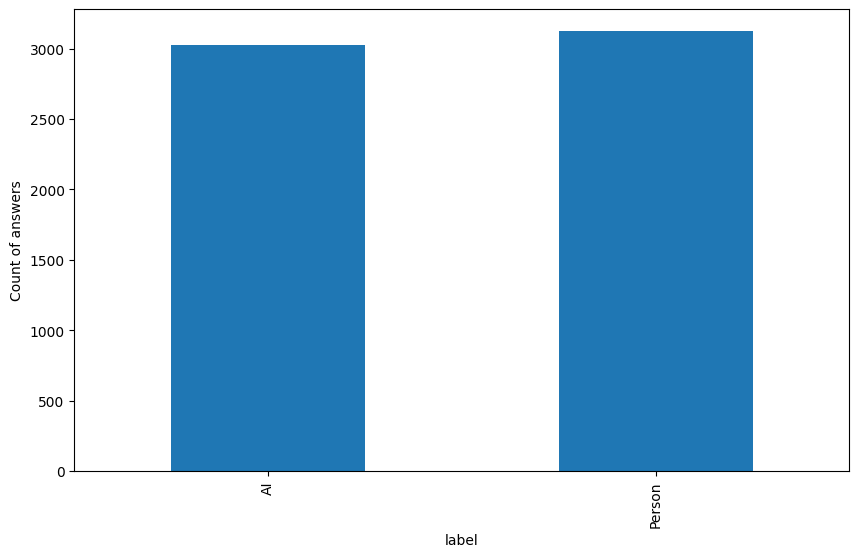

In [ ]:
plt.figure(figsize=(10,6))

train_data.groupby(['label'])['label'].count().plot.bar().set_xticklabels(['AI', 'Person'])
plt.ylabel('Count of answers')

plt.show()

Проверили гипотезу, что ответ от ИИ может отличаться то человеческого длиной текста. Но это оказалось не так.

In [ ]:
train_data['answer_length'] = train_data.apply(lambda x: len(x[1]), axis=1)


In [ ]:
train_data.groupby(['label'])['answer_length'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
ai,3028.0,59.315720,40.229200,1.0,32.0,53.0,74.0,570.0
people,3123.0,43.215818,28.260823,1.0,23.0,37.0,58.0,480.0


In [ ]:
train_data['label'] = train_data['label'].apply(lambda x: 1 if str(x) == 'people' else 0) # people = 1

In [ ]:
train_data.head()

,context,answer,label,answer_length
0,**Вы:** Спасибо большое)).\nКакую музыку слуша...,"Ой, ну тогда давай я тебе порекомендую что-ниб...",0,331
1,**Вы:** Я тоже не замужем. Ищу своего принца. ...,"Может быть и тихие, но совсем не мирные, могут...",1,80
2,**Вы:** Ивановская область.\n\n**Собеседник:**...,В деревне у меня на даче.,0,25
3,**Вы:** Особенно чинить их.\n\n**Собеседник:**...,"В доме - полный порядок, все на своем месте.",0,44
4,**Вы:** В свободное время.\n\n**Собеседник:** ...,"Да, я фотографирую, это моя страсть и хобби.",0,44


In [ ]:
n = 1
train_data.iloc[n]['context'], train_data.iloc[n]['answer'], train_data.iloc[n]['label']

('**Вы:** Я тоже не замужем. Ищу своего принца. А пока толькоу меня замечательный пёсик.\r\nА у вас есть питомцы?\n\n**Собеседник:** У меня дома живут только рыбки в аквариуме, единственныесущества, которых я люблю.\n\n**Вы:** Рыбки тихие и не причинят дискомфорт. Мой пёсик погрызвсе фиалки, а их так долго выращивала.',
 'Может быть и тихие, но совсем не мирные, могут и подраться и слопать друг друга.',
 1)

# text cleaning

In [ ]:
stopwords.words('russian')[:10]

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']

In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
def clean_text(text):
    table = text.maketrans(dict.fromkeys(string.punctuation)) # {Punc: None}

    words = word_tokenize(text.lower().strip().translate(table)) # change Punc to None -> token

    words = [word for word in words if word not in stopwords.words('russian')]

    lemmed = [WordNetLemmatizer().lemmatize(word) for word in words]
    return " ".join(lemmed)

In [ ]:
# train_data['text'] = train_data['context'] + train_data['answer']

In [ ]:
train_data['context'] = train_data['context'].apply(clean_text)
train_data.head()

,context,answer,label,answer_length
0,спасибо большое какую музыку слушаешь собеседн...,"Ой, ну тогда давай я тебе порекомендую что-ниб...",0,331
1,замужем ищу своего принца пока толькоу замечат...,"Может быть и тихие, но совсем не мирные, могут...",1,80
2,ивановская область собеседник понял москве люб...,В деревне у меня на даче.,0,25
3,особенно чинить собеседник люблю стиралки кари...,"В доме - полный порядок, все на своем месте.",0,44
4,свободное время собеседник увлекаешься фотграф...,"Да, я фотографирую, это моя страсть и хобби.",0,44


In [ ]:
train_data.head()

,context,answer,label,answer_length
0,спасибо большое какую музыку слушаешь собеседн...,"Ой, ну тогда давай я тебе порекомендую что-ниб...",0,331
1,замужем ищу своего принца пока толькоу замечат...,"Может быть и тихие, но совсем не мирные, могут...",1,80
2,ивановская область собеседник понял москве люб...,В деревне у меня на даче.,0,25
3,особенно чинить собеседник люблю стиралки кари...,"В доме - полный порядок, все на своем месте.",0,44
4,свободное время собеседник увлекаешься фотграф...,"Да, я фотографирую, это моя страсть и хобби.",0,44


In [ ]:
# train_data['clean_answer_length'] = train_data.apply(lambda x: len(x[1]), axis=1)
length_hypo = train_data.groupby(['label'])['answer_length'].describe()
length_hypo.index = ['Ai', 'Person']

In [ ]:
length_hypo = length_hypo.drop(['count'], axis=1)
length_hypo

,mean,std,min,25%,50%,75%,max
Ai,59.315720,40.229200,1.0,32.0,53.0,74.0,570.0
Person,43.215818,28.260823,1.0,23.0,37.0,58.0,480.0


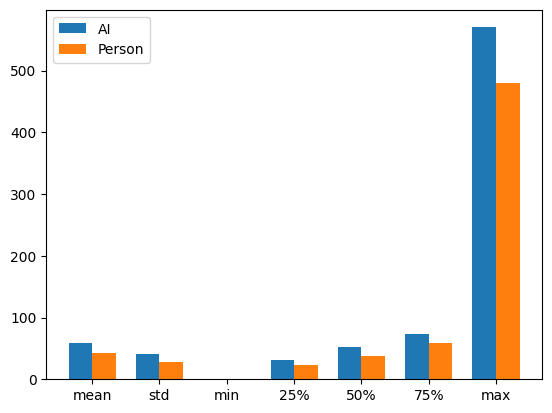

<Figure size 1000x600 with 0 Axes>

In [ ]:

index = np.arange(7)
bar_width = 0.35
fig, ax = plt.subplots()
plt.figure(figsize=(10,6))

AI = ax.bar(index, length_hypo.iloc[0], bar_width,
                label="AI")
Person  = ax.bar(index+bar_width, length_hypo.iloc[1], bar_width,
                label="Person")

ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(length_hypo.columns.values.tolist())
ax.legend()
plt.show()

In [ ]:
train_data.head()

,context,answer,label,answer_length
0,спасибо большое какую музыку слушаешь собеседн...,"Ой, ну тогда давай я тебе порекомендую что-ниб...",0,331
1,замужем ищу своего принца пока толькоу замечат...,"Может быть и тихие, но совсем не мирные, могут...",1,80
2,ивановская область собеседник понял москве люб...,В деревне у меня на даче.,0,25
3,особенно чинить собеседник люблю стиралки кари...,"В доме - полный порядок, все на своем месте.",0,44
4,свободное время собеседник увлекаешься фотграф...,"Да, я фотографирую, это моя страсть и хобби.",0,44


In [ ]:
train_data.head()

,context,answer,label,answer_length
0,спасибо большое какую музыку слушаешь собеседн...,"Ой, ну тогда давай я тебе порекомендую что-ниб...",0,331
1,замужем ищу своего принца пока толькоу замечат...,"Может быть и тихие, но совсем не мирные, могут...",1,80
2,ивановская область собеседник понял москве люб...,В деревне у меня на даче.,0,25
3,особенно чинить собеседник люблю стиралки кари...,"В доме - полный порядок, все на своем месте.",0,44
4,свободное время собеседник увлекаешься фотграф...,"Да, я фотографирую, это моя страсть и хобби.",0,44


In [ ]:
from sklearn.model_selection import train_test_split
X = train_data.drop([
    # 'answer_length',
    # 'clean_answer_length',
    # 'context',
    'label'
    ], axis=1)
y = train_data['label']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
X.head()

,context,answer,answer_length
0,спасибо большое какую музыку слушаешь собеседн...,"Ой, ну тогда давай я тебе порекомендую что-ниб...",331
1,замужем ищу своего принца пока толькоу замечат...,"Может быть и тихие, но совсем не мирные, могут...",80
2,ивановская область собеседник понял москве люб...,В деревне у меня на даче.,25
3,особенно чинить собеседник люблю стиралки кари...,"В доме - полный порядок, все на своем месте.",44
4,свободное время собеседник увлекаешься фотграф...,"Да, я фотографирую, это моя страсть и хобби.",44


# Model

## CatBoost (Первая версия классификатора)

In [ ]:
catboost_scores = {
    'contex + answer + len': None,
    'contex + answer': None,
    'only answer': None,
}

In [ ]:
list(Xtrain)

['context', 'answer', 'answer_length']

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
text_features = ['context','answer']


train_pool = Pool(
    Xtrain,
    ytrain,
    text_features=text_features,
    feature_names=list(Xtrain)
)
valid_pool = Pool(
    Xtest,
    ytest,
    text_features=text_features,
    feature_names=list(Xtrain)
)

catboost_params = {
    'iterations': 10000,
    'learning_rate': 0.001,
    'eval_metric': 'F1',
    'task_type': 'CPU',
    'early_stopping_rounds': 300,
    'use_best_model': True,
    'verbose': 100
}

model = CatBoostClassifier(**catboost_params)
model.fit(train_pool, eval_set=valid_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7951500	test: 0.8274854	best: 0.8274854 (0)	total: 297ms	remaining: 49m 28s
100:	learn: 0.8014052	test: 0.8265647	best: 0.8276850 (62)	total: 44.6s	remaining: 1h 12m 52s
200:	learn: 0.8024870	test: 0.8252753	best: 0.8276850 (62)	total: 1m 18s	remaining: 1h 4m 7s
300:	learn: 0.8019925	test: 0.8260661	best: 0.8276850 (62)	total: 1m 56s	remaining: 1h 2m 28s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.8276849642
bestIteration = 62

Shrink model to first 63 iterations.


In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
catboost_scores = {
    'contex + answer + len': 0.83800,
    'contex + answer': 0.80800,
    'only answer': 0.82500,
}

In [ ]:
for key in catboost_scores.keys():
  print(key, catboost_scores[key])

contex + answer + len 0.838
contex + answer 0.808
only answer 0.825


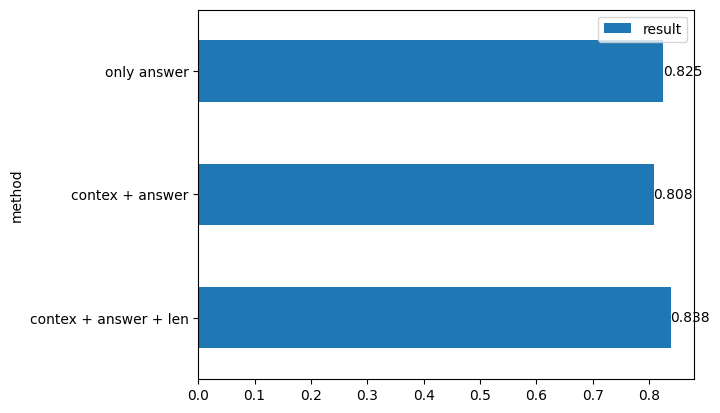

In [ ]:
metrics=pd.DataFrame({'method': [key for key in catboost_scores.keys()], 'result': [catboost_scores[key] for key in catboost_scores.keys()]})

ax = metrics.plot.barh(x='method', y='result', ylim=(0.5,1))

for container in ax.containers:
    ax.bar_label(container)

## Transformers

In [ ]:
!pip install simpletransformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.7/250.7 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 81.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 92.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 123.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.1/205.1 kB 21.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Conversational.(Не рабочий вариант)
Была идея разбить данныек для дообучения gpt предсказывать ответ для ответов с меткой ai. После этого сравнивать с уже готовым столбцом answer. Не получилось из-за нехватки знаний и времени.

In [ ]:
me_context = []
ai_context = []
questions = []

for index, row in train_data.iterrows():
  sentence = row['context']
  me = sentence[:sentence.index('**Собеседник:**')]
  ai = sentence[sentence.index('**Собеседник:**'):sentence[1:].index('**Вы:**')+1]
  q = sentence[sentence[1:].index('**Вы:**'):]

  me_context.append(me)
  ai_context.append(ai)
  questions.append(q)


In [ ]:
train_data['me_context'] = me_context
train_data['ai_context'] = ai_context
train_data['question'] = questions
train_data.head()

,context,answer,label,answer_length,text,clean_text,me_context,ai_context,question
0,**Вы:** Спасибо большое)).\nКакую музыку слуша...,"Ой, ну тогда давай я тебе порекомендую что-ниб...",0,331,**Вы:** Спасибо большое)).\nКакую музыку слуша...,спасибо большое какую музыку слушаешь собеседн...,**Вы:** Спасибо большое)).\nКакую музыку слуша...,**Собеседник:** русский рэп в основном.\nну та...,\n**Вы:** Эм..нет😱.
1,**Вы:** Я тоже не замужем. Ищу своего принца. ...,"Может быть и тихие, но совсем не мирные, могут...",1,80,**Вы:** Я тоже не замужем. Ищу своего принца. ...,замужем ищу своего принца пока толькоу замечат...,**Вы:** Я тоже не замужем. Ищу своего принца. ...,**Собеседник:** У меня дома живут только рыбки...,\n**Вы:** Рыбки тихие и не причинят дискомфорт...
2,**Вы:** Ивановская область.\n\n**Собеседник:**...,В деревне у меня на даче.,0,25,**Вы:** Ивановская область.\n\n**Собеседник:**...,ивановская область собеседник понял москве люб...,**Вы:** Ивановская область.\n\n,**Собеседник:** Понял.\nА я в Москве.\n\n,\n**Вы:** Не люблю шум больших городов.
3,**Вы:** Особенно чинить их.\n\n**Собеседник:**...,"В доме - полный порядок, все на своем месте.",0,44,**Вы:** Особенно чинить их.\n\n**Собеседник:**...,особенно чинить собеседник люблю стиралки кари...,**Вы:** Особенно чинить их.\n\n,**Собеседник:** И тоже люблю стиралки.\n\n,\n**Вы:** Карих слишком много. Зеленые круто.\...
4,**Вы:** В свободное время.\n\n**Собеседник:** ...,"Да, я фотографирую, это моя страсть и хобби.",0,44,**Вы:** В свободное время.\n\n**Собеседник:** ...,свободное время собеседник увлекаешься фотграф...,**Вы:** В свободное время.\n\n,**Собеседник:** Чем ты увлекаешься?\n\n,\n**Вы:** Ты фотграф.\n?\nЛюблю путешествовать?


## CLF

In [ ]:
train_data.head()

,context,answer,label,answer_length,clean_answer_length
0,спасибо большое какую музыку слушаешь собеседн...,"Ой, ну тогда давай я тебе порекомендую что-ниб...",0,331,331
1,замужем ищу своего принца пока толькоу замечат...,"Может быть и тихие, но совсем не мирные, могут...",1,80,80
2,ивановская область собеседник понял москве люб...,В деревне у меня на даче.,0,25,25
3,особенно чинить собеседник люблю стиралки кари...,"В доме - полный порядок, все на своем месте.",0,44,44
4,свободное время собеседник увлекаешься фотграф...,"Да, я фотографирую, это моя страсть и хобби.",0,44,44


In [ ]:
train_transformers = train_data.drop(['answer_length', 'clean_answer_length'], axis=1)

train_transformers['context'] = train_transformers['context'] + train_transformers['answer']
train_transformers = train_transformers.drop(['answer', ], axis=1)
train_transformers.columns = ['text', 'label']
train_transformers.head()

,text,label
0,спасибо большое какую музыку слушаешь собеседн...,0
1,замужем ищу своего принца пока толькоу замечат...,1
2,ивановская область собеседник понял москве люб...,0
3,особенно чинить собеседник люблю стиралки кари...,0
4,свободное время собеседник увлекаешься фотграф...,0


In [ ]:
from sklearn.model_selection import train_test_split
train, eval = train_test_split(train_transformers, test_size=0.15, random_state=42)


In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from sklearn.metrics import f1_score

model_args = ClassificationArgs(
                                num_train_epochs=2,
                                use_early_stopping = True,
                                overwrite_output_dir=True,
                                train_batch_size=8,
                                eval_batch_size=8
                                )

pretrained_models = [
                      ["bert", "amberoad/bert-multilingual-passage-reranking-msmarco"],
                      ["bert", "bert-base-multilingual-cased"],
                      ["xlmroberta", "xlm-roberta-large"],
                      ["xlmroberta", "papluca/xlm-roberta-base-language-detection"]
                    ]

choice = 2

model = ClassificationModel(
    pretrained_models[choice][0], pretrained_models[choice][1], args=model_args
)



Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.den

In [ ]:
# Train the model
model.train_model(train, f1=f1_score)

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval, f1=f1_score)

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/654 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/654 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/923 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/116 [00:00<?, ?it/s]

In [ ]:
result

{'mcc': 0.0,
 'tp': 473,
 'tn': 0,
 'fp': 450,
 'fn': 0,
 'auroc': 0.5143199436222692,
 'auprc': 0.5218267519661964,
 'f1': 0.6776504297994269,
 'eval_loss': 0.6925932785560345}

In [ ]:
f1_scores= [0.819,
  0.842,
  0.678,
  0.837]

metrics = pd.DataFrame({'models': [pretrained_models[i][1] for i in range(4)], 'result':[f1_scores[i] for i in range(4)]})


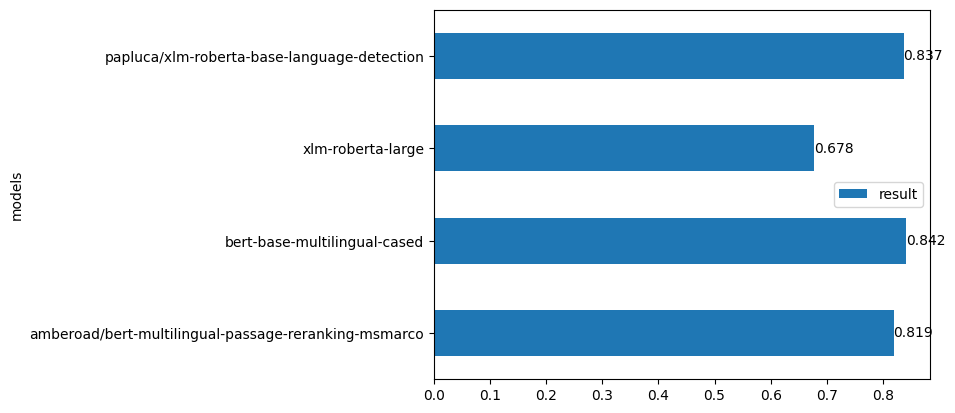

In [ ]:
ax = metrics.plot.barh(x='models', y='result', ylim=(0.5,1))

for container in ax.containers:
    ax.bar_label(container)

# inference

In [ ]:
test_data = pd.read_csv('private_test.csv')
test_data.head()

,context,answer
0,"**Вы:** Спасибо братан,тебя тоже!!!\n\n**Собес...",Краснодар - красивый город. Что тебе там больш...
1,**Вы:** Кем работаешь??\nЯ работаю косметолого...,"Но не знаю, как правильно ухаживать за ними. Я..."
2,**Вы:** Что читали из последнего?\n\n**Собесед...,Это жизнь
3,"**Вы:** Я мёдсистра, люблю путешествовать увле...","Живу в городе, но мечтаюо природе и своем доме"
4,**Вы:** А ты чем-то увлекаешься кроме спорта.\...,Начать никогда не поздно


In [ ]:
test_list = []

for index, row in test_data.iterrows():
  test_list.append(row['answer'])

In [ ]:
predictions, raw_outputs = model.predict(test_list)

  0%|          | 0/2482 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

In [ ]:
# Для catboost

#test_data['text'] = test_data['context'] + test_data['answer']
#test_data['clean_text'] = test_data['text'].apply(clean_text)

# predictions = model.predict(test_data.drop(['context', 'answer', 'text'], axis=1))

In [ ]:
sub_df = pd.DataFrame(predictions, columns=['label_num'])

In [ ]:
sub_df['label'] = sub_df['label_num'].apply(lambda x: 'people' if x == 1 else 'ai')

In [ ]:
sub_df.drop(['label_num'], axis=1).to_csv('rucode_submission.csv', index = False)